In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        f.read(16)
        buffer = f.read()
        data = np.frombuffer(buffer, dtype=np.uint8)
        data = data.reshape(-1, 28, 28)
    return np.array(data)


In [3]:
def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        f.read(8)
        buffer = f.read()
        labels = np.frombuffer(buffer, dtype=np.uint8)
    return np.array(labels)

In [4]:
x_train = load_mnist_images('data/train-images.idx3-ubyte')
y_train = load_mnist_labels('data/train-labels.idx1-ubyte')
x_test = load_mnist_images('data/t10k-images.idx3-ubyte')
y_test = load_mnist_labels('data/t10k-labels.idx1-ubyte')

In [5]:
x_train_flat = x_train.reshape(x_train.shape[0], -1).T / 255.0
x_test_flat = x_test.reshape(x_test.shape[0], -1).T / 255.0

In [6]:
m = x_train_flat.shape[1]
shuffled_indices = np.random.permutation(m)
x_train_flat = x_train_flat[:, shuffled_indices]
y_train = y_train[shuffled_indices]

In [7]:
X_dev = x_train_flat[:, :1000]
Y_dev = y_train[:1000]
X_train = x_train_flat[:, 1000:]
Y_train = y_train[1000:]


In [8]:
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_dev shape: {X_dev.shape}, Y_dev shape: {Y_dev.shape}")

X_train shape: (784, 59000), Y_train shape: (59000,)
X_dev shape: (784, 1000), Y_dev shape: (1000,)


In [9]:
def init_params():
    W1 = np.random.rand(128, 784) - 0.5
    b1 = np.random.rand(128, 1) - 0.5
    W2 = np.random.rand(10, 128) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return expZ / expZ.sum(axis=0, keepdims=True)

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2


In [10]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteração: ", i)
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y)
            print(f"Precisão: {accuracy:.2f}")
    return W1, b1, W2, b2

In [11]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 100)

Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, x_test_flat)
predictions = get_predictions(A2)
test_accuracy = get_accuracy(predictions, y_test)
print(f"Test set accuracy: {test_accuracy:.2f}")

Iteration:  0
Accuracy: 0.09
Iteration:  10
Accuracy: 0.46
Iteration:  20
Accuracy: 0.62
Iteration:  30
Accuracy: 0.69
Iteration:  40
Accuracy: 0.73
Iteration:  50
Accuracy: 0.76
Iteration:  60
Accuracy: 0.78
Iteration:  70
Accuracy: 0.79
Iteration:  80
Accuracy: 0.81
Iteration:  90
Accuracy: 0.82
Test set accuracy: 0.83


In [12]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [8]
Label:  8


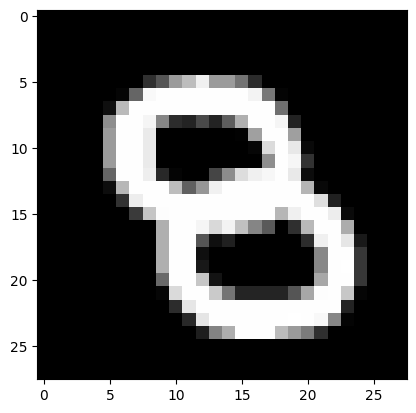

Prediction:  [9]
Label:  8


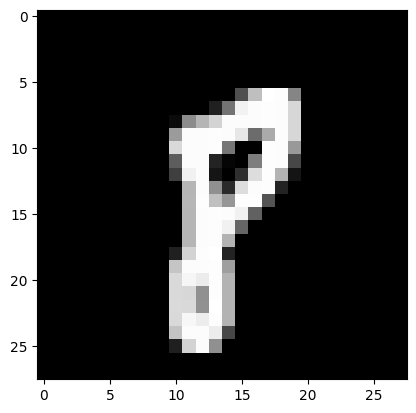

Prediction:  [9]
Label:  9


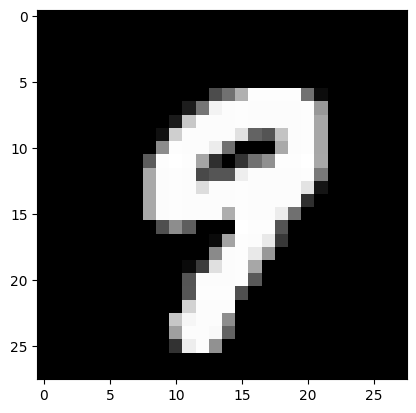

Prediction:  [3]
Label:  5


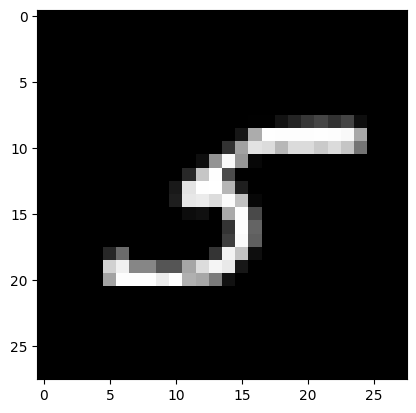

In [13]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)